In [136]:
import csv
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from pprint import pprint

import nltk 
nltk.download('stopwords') 

from nltk.corpus import stopwords
import nltk.stem
import rpy2.robjects as ro
import re
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
%matplotlib inline 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [151]:
filedf = pd.read_csv('total.csv', skipinitialspace=True)

C:\Users\User\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [220]:
d  = filedf.loc[:,['text','label']]
d['label'].value_counts()
# corpus = d['text'].tolist()

0    83614
1    36405
Name: label, dtype: int64

In [221]:
d['Leave'] = (d['label'] == 0 )

In [222]:
d['Leave'].describe()

count     120019
unique         2
top         True
freq       83614
Name: Leave, dtype: object

In [223]:
'''Too many True, need to fix the data'''
dfT = d[d['Leave'] == True]
dfF = d[d['Leave'] == False]

In [224]:
x = dfF.shape[0]

In [225]:
dfT = dfT.iloc[:x, :]

In [226]:
dfT.shape

(36405, 3)

In [227]:
df = pd.concat( [dfT,dfF], axis= 0 )

In [228]:
stopwordsList = stopwords.words('english') + ["pic.twitter"]
r = re.compile(r"[^a-zA-Z]")

In [229]:
def my_tokenizer(tweet):
    tweet = tweet.lower()
    return map( ( lambda i :nltk.stem.PorterStemmer().stem(re.sub(r,'',i)) ) ,
                list(filter(lambda x: x not in stopwordsList,tweet.split())) )

In [230]:
'''Removing sparse terms'''
vectorizer = CountVectorizer(tokenizer = my_tokenizer, min_df=0.005)
X = vectorizer.fit_transform(df['text'].values.astype('str'))

In [231]:
all_terms = vectorizer.get_feature_names()

In [9]:
# features_count = X.sum(axis=0).tolist()[0][1:]
# features_names =  vectorizer.get_feature_names()[1:]
# features = pd.DataFrame(list(zip(features_names, features_count)), 
#                                 columns=['features', 'count']
#                                 ).sort_values(by=['count'], ascending=False)

In [232]:
'''A sparse term document matrix'''
sparse_df = pd.SparseDataFrame([ pd.SparseSeries(X[i].toarray().ravel()) 
                              for i in np.arange(X.shape[0]) ])

In [233]:
sparse_df.drop(sparse_df.columns[0],axis=1,inplace=True)
sparse_df.shape

(72810, 263)

In [234]:
term_freq = sparse_df.sum(axis = 0)
print(sum(term_freq >= 20))

263


In [238]:
sparse_df['Leave'] = df['Leave']
a = [i for i in range(1,sparse_df.shape[1])]

In [275]:
s_df1 = sparse_df[(sparse_df['Leave']==False)]
print(s_df1.shape)
s_df2 = sparse_df[(sparse_df['Leave']==True)]
print(s_df2.shape)

(22237, 264)
(36405, 264)


In [276]:
Sdf = pd.concat( [s_df1, s_df2], axis= 0 )

In [279]:
Sdf['Leave'].value_counts()

True     36405
False    22237
Name: Leave, dtype: int64

In [280]:
from sklearn.model_selection import train_test_split
S_train, S_test, yrg_train, yrg_test = train_test_split(
        Sdf[a], Sdf['Leave'],
        test_size=0.4, random_state=123)

# Random Forests

In [352]:
from sklearn.ensemble import RandomForestClassifier
tweetRF = RandomForestClassifier(n_estimators=100, criterion='entropy', oob_score = True, random_state = 123)
tweetRF.fit(S_train, list(yrg_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=123,
            verbose=0, warm_start=False)

In [359]:
predictRF = tweetRF.predict(S_test)

In [360]:
metrics.f1_score(list(yrg_test), list(predictRF), average= 'binary')

0.68985863552550708

# Logistic Regression

In [286]:
from sklearn.linear_model import LogisticRegression
tweetRF = LogisticRegression(penalty= 'l2', C = 0.005, random_state= 123, n_jobs = -1)

In [296]:
tweetRF.fit(S_train, list(yrg_train))

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [299]:
predictRF = tweetRF.predict(S_test )

In [300]:
metrics.f1_score(list(yrg_test), list(predictRF), average= 'binary')

0.76853212935741289

# Linear Regression

In [312]:
y = list (map((lambda x: 0 if x == True else 1 ),(list(yrg_train))))

In [313]:
from sklearn.linear_model import LinearRegression
tweetRF = LinearRegression(normalize = True, n_jobs = -1)
tweetRF.fit(S_train,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [314]:
predictRF = tweetRF.predict(S_test)

In [335]:
f1_scores = []
thresholdList = list( np.arange(0.15,0.7,0.01))
y_actual  = list (map((lambda x: 0 if x == True else 1 ),(list(yrg_test))))

for t in thresholdList:
    
    pred = list ( map( ( lambda x: 0 if (x < t) else 1 ),( list(predictRF) ) ) )
    
    f1s = metrics.f1_score(y_actual, pred, average = 'binary' )
    
    f1_scores.append(f1s)

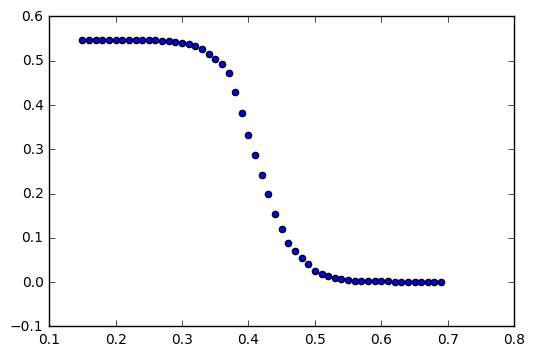

In [346]:
plt.scatter(thresholdList,f1_scores) 

In [361]:
'''At a threshold of 0.2 you can expect an F-1 score of 0.55'''

'At a threshold of 0.2 you can expect an F-1 score of 0.55'